In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from tqdm.notebook import tqdm, trange
from matplotlib.ticker import FormatStrFormatter
from scipy.special import expit
import pickle

In [3]:
from mriutils import plot_preds

### Plotting functions - example

Raw sensitivity: 0.8881789137380192


  0%|          | 0/2000 [00:00<?, ?it/s]

AUROC: 0.9243542593659854 (0.9142290035370849-0.9339714686072499)
AUPRC: 0.7198448936634592 (0.6868298879852277-0.7509147972726354)
Sens: 0.8881791512355116 (0.8673088088249524-0.9085041070585719)
spec: 0.770884719784226 (0.7611327396582562-0.7810242462076143)
ppv: 0.34416693083153166 (0.32486115053879455-0.362714236146512)
npv: 0.9807425202384307 (0.9769071550381905-0.9844093910491563)


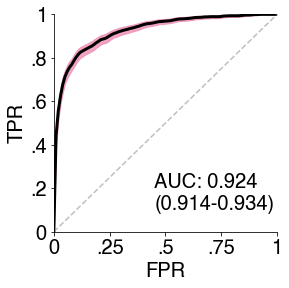

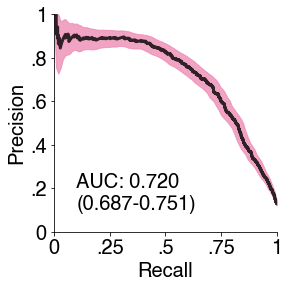

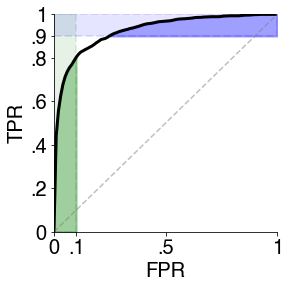

In [46]:
nyu_rd = plot_preds(df2, n_bootstraps=2000, color1hex='#000000', color2hex='#ed85b0', savefig_name='nyu', proc=True, decision_threshold=0.045)

### Bring Your Own Preds:

In [4]:
df = pd.read_csv("/predictions.csv")

In [ ]:
plot_preds(df.labels, df.preds, n_bootstraps=2000, savefig_name='uj', color1hex='#000000', color2hex='#ed85b0', proc=True)

### Mini plot combined

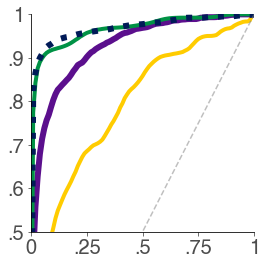

In [55]:
plt.rcParams['text.color'] = '#4d4d4d'
plt.rcParams['xtick.color'] = '#4d4d4d'
plt.rcParams['ytick.color'] = '#4d4d4d'

plt.figure(figsize=(4,4))
for ds, lc, ls, lw in zip([uj_rd, nyu_rd, tcga_rd, duke_rd], ["#ffcc00", "#5b0f8d", "#009245", "#001a57"], ['-', '-', '-', ':'], [4, 6, 4, 6]):
    plt.plot(ds['base_fpr'], ds['mean_tprs'], color=lc, lw=lw, linestyle=ls)
    #plt.plot(base_fpr, mean_tprs, color=color1hex, lw=3)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=color2hex, alpha=0.3)
plt.plot([0, 1], [0, 1],'--',c='grey',alpha=0.5)
ax = plt.gca()
ax.set_xlim([0, 1.00])
ax.set_ylim([0.5, 1.00])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_formatter(leading_zeros_formatter)
ax.yaxis.set_major_formatter(leading_zeros_formatter)
plt.savefig(f"mini_roc_datasets.pdf", bbox_inches='tight')

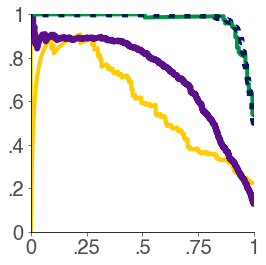

In [56]:
plt.rcParams['text.color'] = '#4d4d4d'
plt.rcParams['xtick.color'] = '#4d4d4d'
plt.rcParams['ytick.color'] = '#4d4d4d'

plt.figure(figsize=(4,4))
for ds, lc, ls, lw in zip([uj_rd, nyu_rd, tcga_rd, duke_rd], ["#ffcc00", "#5b0f8d", "#009245", "#001a57"], ['-', '-', '-', ':'], [4, 6, 4, 6]):
    plt.plot(ds['recall'], ds['precision'], color=lc, lw=lw, linestyle=ls)
    #plt.plot(base_fpr, mean_tprs, color=color1hex, lw=3)
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=color2hex, alpha=0.3)

ax = plt.gca()
ax.set_xlim([0, 1.00])
ax.set_ylim([0, 1.00])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_formatter(leading_zeros_formatter)
ax.yaxis.set_major_formatter(leading_zeros_formatter)
plt.savefig(f"mini_prc_datasets.pdf", bbox_inches='tight')

## Subgroup analysis plot

In [211]:
with open("/blinded.pkl", "rb") as f:
    subgroup_dict = pickle.load(f)

In [212]:
df_sub = pd.DataFrame(columns=['auroc', 'auprc', 'sens', 'spec'])
plot_dictionary = {
    "BIRADS": ["BIRADS 0",  "BIRADS 4", "BIRADS 5", "BIRADS 6"],  #  "BIRADS 1_2_3" excluded
    "BPE": ["Minimal", "Mild", "Moderate", "Marked"],
    "Race": ["White", "Black", "Asian", "Other Race"],
    "Histology": ["IDC", "DCIS", "ILC", "Meta", "IMC", "Adenoca"],#, "Papillary", "Lymphoma"],
    "Molecular": ["Luminal A", "Luminal B", "Triple negative", "HER2-enriched"],
}




for plot_group, plot_subgroups in plot_dictionary.items():
    for plot_subgroup in plot_subgroups:
        x = subgroup_dict[plot_group][plot_subgroup]
        df_sub = df_sub.append({"auroc": x['AUROC malignant'], "auprc": x['AUPRC'], "sens": x['Sensitivity'], "spec": x['Specificity']}, ignore_index=True)

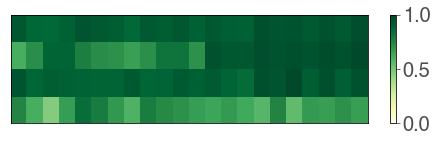

In [216]:
plt.figure(figsize=(8,2))
plt.pcolor(df_sub.T.iloc[::-1], cmap='YlGn', vmin=0, vmax=1)
plt.yticks([])
plt.xticks([])
plt.colorbar()
plt.savefig('mini_subgroup_res.pdf', bbox_inches='tight')

#### Reader study mock plot

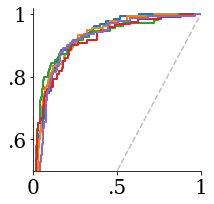

In [632]:
plt.figure(figsize=(3, 3))
fprs = []
tprs = []
for _ in range(5):
    random_idxs = np.random.choice(np.arange(0, len(df2.preds)), size=1050)
    fpr, tpr, _ = roc_curve(df2.labels[random_idxs], expit(df2.preds[random_idxs]))
    fprs.append(fpr)
    tprs.append(fpr)
    plt.plot(fpr, tpr, lw=2)

random_idxs = np.random.choice(np.arange(0, len(df2.preds)), size=10500)
fpr, tpr, _ = roc_curve(df2.labels[random_idxs], expit(df2.preds[random_idxs]))
fprs.append(fpr)
tprs.append(fpr)

plt.plot([0, 1], [0, 1],'--',c='grey',alpha=0.5)
plt.xlim([0.0, 1.00])
plt.ylim([0.50, 1.02])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_formatter(leading_zeros_formatter)
ax.yaxis.set_major_formatter(leading_zeros_formatter)
plt.savefig('dummy_readerstudy_roc.pdf', bbox_inches='tight')

#### Reader study - hybrids - mock plot

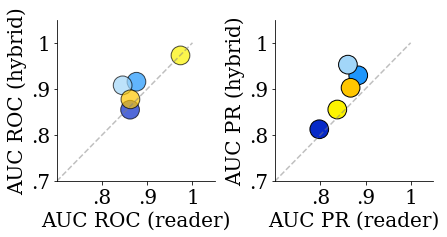

In [643]:
x = np.random.uniform(0.75, 0.99, size=5)  # mock initial AUROCs
improvements = np.random.uniform(-0.02,0.08, size=5)
y = x + improvements
y = np.clip(y, 0, 1.0)

fig, ax = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
ax[0].scatter(x, y, s=350, color=['#072AC8', '#1E96FC', '#A2D6F9', '#FCF300', '#FFC600'], edgecolors='black', alpha=0.7)
ax[0].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
ax[0].set_xlabel('AUC ROC (reader)')
ax[0].set_ylabel('AUC ROC (hybrid)')
ax[0].set_xlim([0.7, 1.05])
ax[0].set_ylim([0.7, 1.05])

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xticks([0.8, 0.9, 1])
ax[0].xaxis.set_major_formatter(leading_zeros_formatter)
ax[0].yaxis.set_major_formatter(leading_zeros_formatter)


x = np.random.uniform(0.75,0.99, size=5)  # mock initial AUROCs
improvements = np.random.uniform(-0.01,0.10, size=5)
y = x + improvements
y = np.clip(y, 0, 1)

ax[1].scatter(x, y, s=350, color=['#072AC8', '#1E96FC', '#A2D6F9', '#FCF300', '#FFC600'], edgecolors='black')
ax[1].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
ax[1].set_xlabel('AUC PR (reader)')
ax[1].set_ylabel('AUC PR (hybrid)')
ax[1].set_xlim([0.70, 1.05])
ax[1].set_ylim([0.70, 1.05])
ax[1].set_xticks([0.8, 0.9, 1])
#ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].xaxis.set_major_formatter(leading_zeros_formatter)
ax[1].yaxis.set_major_formatter(leading_zeros_formatter)

plt.savefig('dummy_readerstudy_hybrids.pdf')

### Empty AUROC plots for all readers

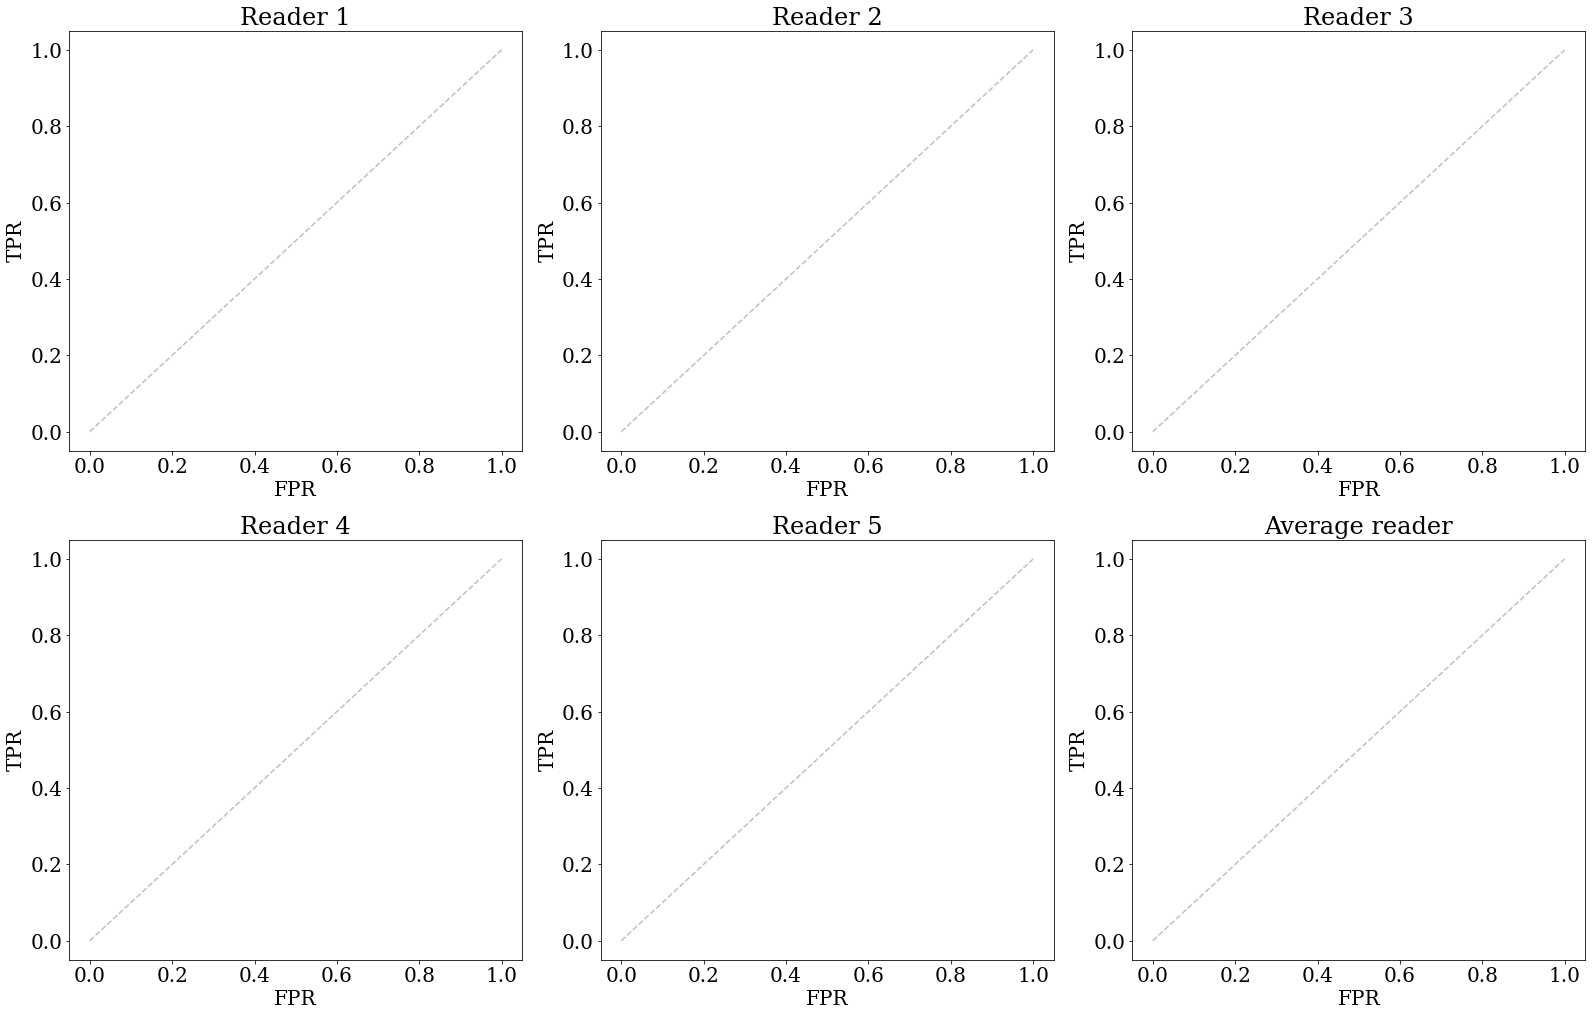

In [557]:
fig, axes = plt.subplots(2, 3, figsize=(22,14), constrained_layout=True)
axes[0,0].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[0,0].set_xlabel('FPR')
axes[0,0].set_ylabel('TPR')
axes[0,0].set_title('Reader 1')

axes[0,1].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[0,1].set_xlabel('FPR')
axes[0,1].set_ylabel('TPR')
axes[0,1].set_title('Reader 2')

axes[0,2].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[0,2].set_xlabel('FPR')
axes[0,2].set_ylabel('TPR')
axes[0,2].set_title('Reader 3')

axes[1,0].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[1,0].set_xlabel('FPR')
axes[1,0].set_ylabel('TPR')
axes[1,0].set_title('Reader 4')

axes[1,1].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[1,1].set_xlabel('FPR')
axes[1,1].set_ylabel('TPR')
axes[1,1].set_title('Reader 5')

axes[1,2].plot( [0,1],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[1,2].set_xlabel('FPR')
axes[1,2].set_ylabel('TPR')
axes[1,2].set_title('Average reader')
plt.savefig('empty_readerstudy_rocs.pdf')

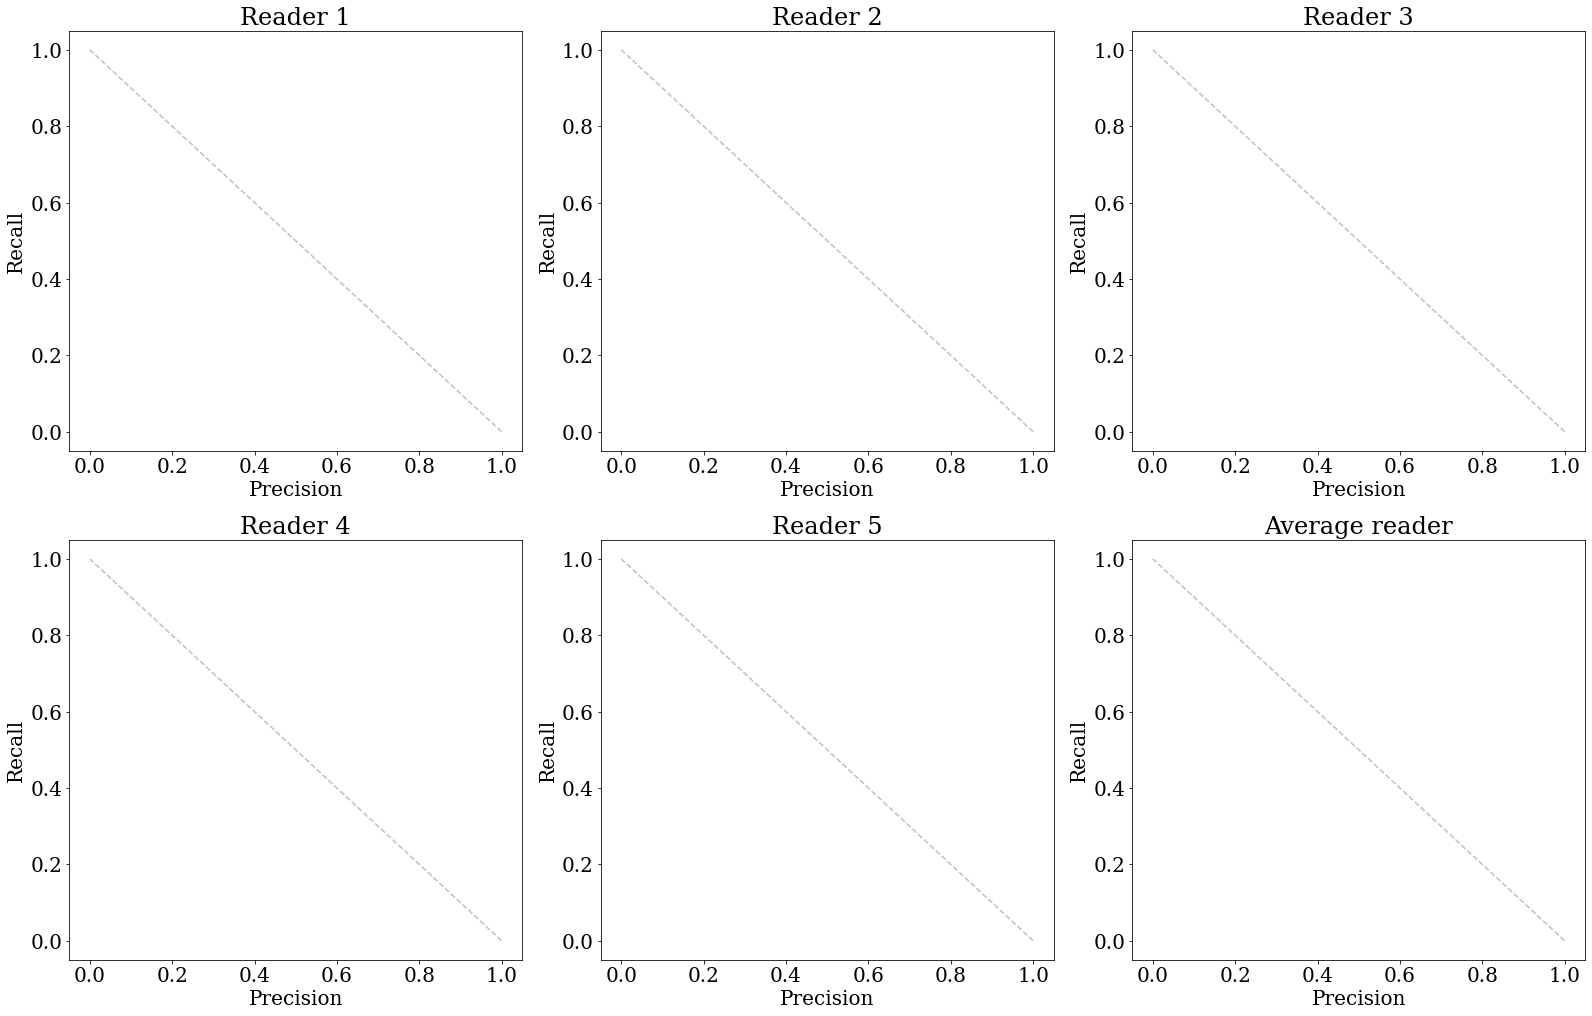

In [561]:
fig, axes = plt.subplots(2, 3, figsize=(22,14), constrained_layout=True)
axes[0,0].plot( [1,0],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[0,0].set_xlabel('Precision')
axes[0,0].set_ylabel('Recall')
axes[0,0].set_title('Reader 1')

axes[0,1].plot( [1,0],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[0,1].set_xlabel('Precision')
axes[0,1].set_ylabel('Recall')
axes[0,1].set_title('Reader 2')

axes[0,2].plot( [1,0],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[0,2].set_xlabel('Precision')
axes[0,2].set_ylabel('Recall')
axes[0,2].set_title('Reader 3')

axes[1,0].plot( [1,0],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[1,0].set_xlabel('Precision')
axes[1,0].set_ylabel('Recall')
axes[1,0].set_title('Reader 4')

axes[1,1].plot( [1,0],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[1,1].set_xlabel('Precision')
axes[1,1].set_ylabel('Recall')
axes[1,1].set_title('Reader 5')

axes[1,2].plot( [1,0],[0,1], '--', color='grey', alpha=0.5)  #identity
axes[1,2].set_xlabel('Precision')
axes[1,2].set_ylabel('Recall')
axes[1,2].set_title('Average reader')
plt.savefig('empty_readerstudy_prc.pdf')

### Mock net benefit

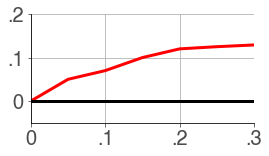

In [43]:
plt.figure(figsize=(4,2))
plt.plot([0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], [0.00, 0.05, 0.07, 0.10, 0.12, 0.125, 0.129], c='red', lw=3)
plt.plot([0, 0.3], [0, 0], c='black', lw=3)
plt.grid(which='both')
ax = plt.gca()
ax.set_xlim([0.0, 0.3])
ax.set_ylim([-0.05, 0.2])
ax.set_xticks([0.0, 0.1, 0.2, 0.3])
ax.set_yticks([0, 0.1, 0.2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_major_formatter(leading_zeros_formatter)
ax.yaxis.set_major_formatter(leading_zeros_formatter)
plt.savefig("net_benefit_mini.pdf", bbox_inches='tight')